In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from healthanalyzer import HealthAnalyzer
from utils import (get_stats, fit_bp_regression, plot_bp_vs_age, plot_bp_vs_weight, compute_basic_stats, plot_bp_histogram, 
                   plot_weight_boxplot_by_sex, compute_smoking_counts, plot_smoking_by_sex, simulate_disease_prevalence, 
                   compute_disease_prevalence_by_sex, plot_disease_prevalence_by_sex, bootstrap_bp_difference_by_smoking)

df = pd.read_csv("data/health_study_dataset.csv")
np.random.seed(42)
analyzer = HealthAnalyzer(df)

## Del 2

### Kodstruktur

För att strukturera koden skapade jag klassen `HealthAnalyzer`, den innehåller metoder för att beräkna konfidensintervall och utföra simuleringar, 
och används sedan i notebooken för själva analysen.
Mestadels av koden flyttades till `utils.py` för att städa upp notebooken.

### Linjär algebra

För att visa linjär algebra i praktiken användes en linjär regressionsmodell för att förutsäga blodtryck baserat på ålder och vikt. 

Regressionen genomfördes med hjälp av scikit-learn, och resulterade i en modell där varje koefficient beskriver hur blodtrycket förändras vid en enhetsförändring i respektive variabel, givet att övriga variabler hålls konstanta.

För att tolka modellen och visualisera sambanden användes både jämförelser mellan förutsagda och observerade värden samt partiella grafer, där en variabel i taget varierades medan den andra hölls konstant.

### Ny graf för sjukdomsförekomst per kön

För att ge en djupare förståelse av datan lades även en graf av sjukdomsförekomst uppdelat efter kön till.
Genom att jämföra andelen individer med sjukdom mellan kvinnor och män blir det möjligt att identifiera eventuella skillnader
som inte framgår i tidigare analyser.

Denna graf kompletterar övriga analyser och ger ytterligare kontext till hur sjukdom är fördelad i populationen.

Intercept (β0): 109.499
Ålder koeff (β1): 0.539
Vikt koeff (β2): 0.178
R^2: 0.405


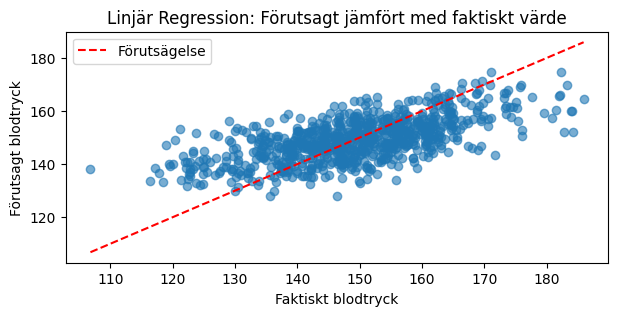

In [2]:
model, data, X, y, y_pred = fit_bp_regression(df)

print(f"Intercept (β0): {model.intercept_:.3f}")
print(f"Ålder koeff (β1): {model.coef_[0]:.3f}")
print(f"Vikt koeff (β2): {model.coef_[1]:.3f}")
print(f"R^2: {model.score(X, y):.3f}")

plt.figure(figsize=(7,3))
plt.scatter(y, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle="--", color="red", label="Förutsägelse")
plt.xlabel("Faktiskt blodtryck")
plt.ylabel("Förutsagt blodtryck")
plt.title("Linjär Regression: Förutsagt jämfört med faktiskt värde")
plt.legend()
plt.show()

### Förutsagda värden jämfört med observerade värden

Figuren ovan visar förutsagda värden från den linjära regressionsmodellen jämfört med de observerade blodtrycksvärdena. 

Eftersom modellen bygger på två variabler (ålder och vikt) är det dock svårt att utläsa hur respektive variabel 
påverkar blodtrycket direkt från denna graf.

För att tydligare visa hur ålder respektive vikt påverkar blodtrycket jämförs dessa variabler var för sig i följande grafer, 
där den andra variabeln hålls konstant.

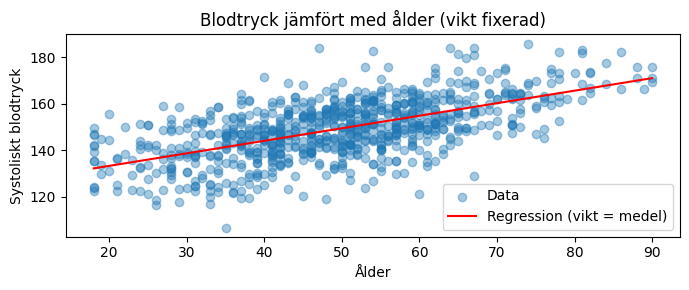

In [3]:
plot_bp_vs_age(model, data, y)

### Blodtryck jämfört med ålder

Grafen visar sambandet mellan ålder och blodtryck, där vikten har fixerats till sitt medelvärde. 
Datan indikerar en tydlig positiv trend, vilket innebär att blodtrycket i genomsnitt ökar med stigande ålder.

Den anpassade regressionslinjen visar att ökningen är relativt jämn över åldersspannet. 
Detta överensstämmer med regressionskoefficienten för ålder, som indikerar att blodtrycket ökar med ungefär 0.5 enheter per år, givet att vikten hålls konstant.

Samtidigt syns en tydlig spridning kring linjen, vilket tyder på att ålder ensam inte förklarar hela variationen i blodtrycket.

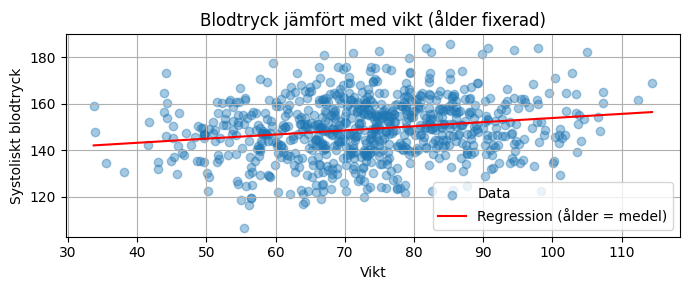

In [4]:
plot_bp_vs_weight(model, data, y)

### Blodtryck jämfört med vikt

Grafen visar sambandet mellan vikt och blodtryck, där åldern har fixerats till sitt medelvärde. 
Datan uppvisar en svagt positiv trend, vilket innebär att blodtrycket i genomsnitt ökar något med högre vikt.

Den anpassade regressionslinjen har dock en betydligt flackare lutning jämfört med grafen för ålder, vilket indikerar 
att vikten har en svagare påverkan på blodtrycket än åldern i denna modell. Detta överensstämmer med regressionskoefficienten 
för vikt, som är lägre än motsvarande för ålder.

Den relativt stora spridningen kring linjen tyder på att vikt ensam endast förklarar en mindre del av variationen i blodtrycket.



### Uträkning av medel, median, min och max för age, weight, heigh, systolic_bp och cholesterol

In [5]:
stats_summary = compute_basic_stats(df)

for name, stats in stats_summary.items():
    print(
        f"{name}\n"
        f"mean: {stats['mean']:.2f}\n"
        f"median: {stats['median']:.2f}\n"
        f"min: {stats['min']:.2f}\n"
        f"max: {stats['max']:.2f}\n"
    )

Age
mean: 49.43
median: 50.00
min: 18.00
max: 90.00

Weight
mean: 73.41
median: 73.20
min: 33.70
max: 114.40

Height
mean: 171.85
median: 171.35
min: 144.40
max: 200.40

Systolic BP
mean: 149.18
median: 149.40
min: 106.80
max: 185.90

Cholesterol
mean: 4.93
median: 4.97
min: 2.50
max: 7.88



### Histogram över blodtryck

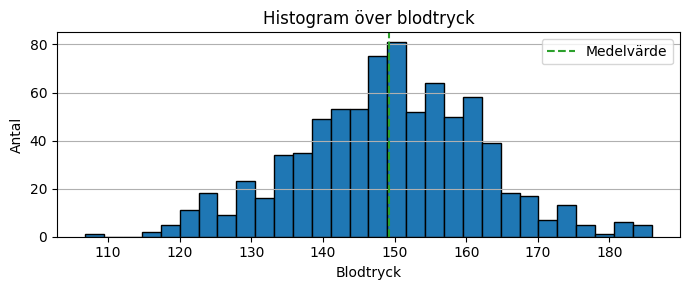

In [6]:
data = df.systolic_bp
stats_bp = get_stats(data)

plot_bp_histogram(data, stats_bp)

### Boxplot över vikt per kön

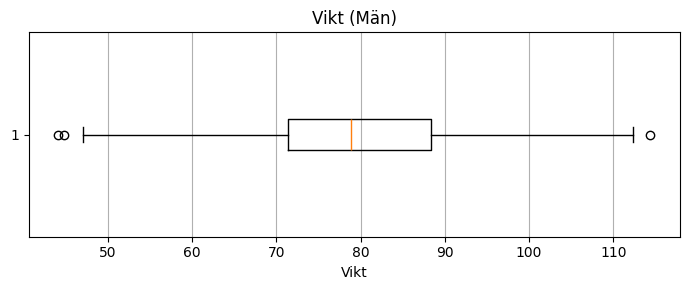

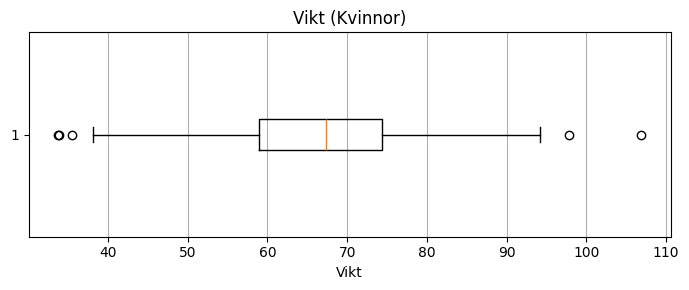

In [7]:
plot_weight_boxplot_by_sex(df, "M")

plot_weight_boxplot_by_sex(df, "F")

### Stapeldiagram över andelen rökare

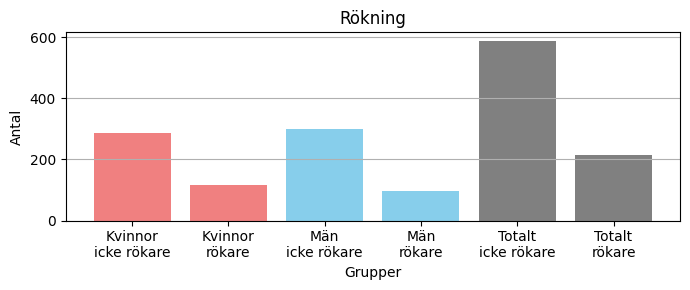

In [8]:
labels, values, colors = compute_smoking_counts(df)
plot_smoking_by_sex(labels, values, colors)

### Simulering

In [9]:
results = simulate_disease_prevalence(df, n_sim=1000)

print(
    f"Antal människor med sjukdom från dataset: {results['n_with_disease']}\n"
    f"Vilket är {results['true_rate']*100:.2f}% av populationen\n"
)

print(
    f"Antal människor med sjukdom från simulering: {results['simulated_cases']}\n"
    f"Vilket är {results['simulated_rate']*100:.2f}% av stickprovet\n"
)

print(
    f"Standardavvikelsen är: {results['std']:.1f}\n"
    f"Förväntade fall från simuleringen var: {results['expected_cases']:.1f}\n"
)

lo, hi = results["normal_interval"]
print(
    f"Faktiska fall från simuleringen: {results['simulated_cases']}\n"
    f"Normalintervall: {lo:.1f} – {hi:.1f}"
)

Antal människor med sjukdom från dataset: 47
Vilket är 5.88% av populationen

Antal människor med sjukdom från simulering: 56
Vilket är 5.60% av stickprovet

Standardavvikelsen är: 7.4
Förväntade fall från simuleringen var: 58.8

Faktiska fall från simuleringen: 56
Normalintervall: 51.3 – 66.2


### Sjukdomsförekomst per kön

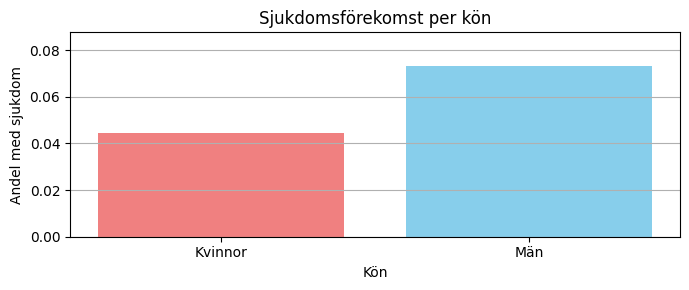

In [10]:
labels, values, colors = compute_disease_prevalence_by_sex(df)
plot_disease_prevalence_by_sex(labels, values, colors)

Figuren visar andelen individer med sjukdom uppdelat efter kön.
Resultatet indikerar en skillnad i sjukdomsförekomst mellan kvinnor och män, där män har en ökad, om än liten risk att vara drabbade av sjukdom.

### Konfidensintervall för medelvärdet av systolic_bp med Bootstrap

In [11]:
systolic_bp = df.systolic_bp
true_mean = float(np.mean(systolic_bp))
sample = np.random.choice(systolic_bp, 40)

Bootstrap-CI: 142.4 - 151.0
Stickprovsmedel: 146.7     Sant medel: 149.2


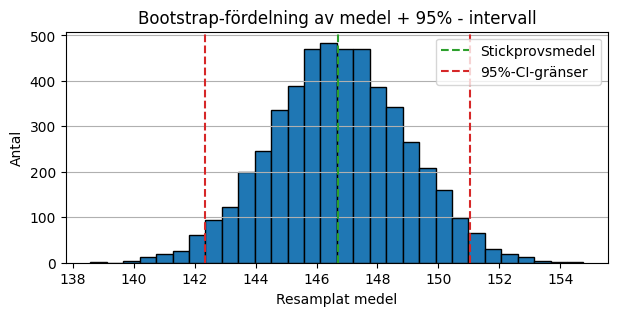

In [12]:
blo, bhi, bmean, boot_means = analyzer.ci_mean_bootstrap(sample)

fig, ax = plt.subplots(figsize=(7,3))

ax.hist(boot_means, bins=30, edgecolor="black")
ax.axvline(bmean, color="tab:green", linestyle="--", label="Stickprovsmedel")
ax.axvline(blo, color="tab:red", linestyle="--", label="95%-CI-gränser")
ax.axvline(bhi, color="tab:red", linestyle="--")
ax.set_title("Bootstrap-fördelning av medel + 95% - intervall")
ax.set_xlabel("Resamplat medel")
ax.set_ylabel("Antal")
ax.grid(True, axis="y")
ax.legend()

print(f"Bootstrap-CI: {blo:.1f} - {bhi:.1f}")
print(f"Stickprovsmedel: {bmean:.1f}     Sant medel: {true_mean:.1f}")

### Konfidensintervall för medelvärdet av systolic_bp med normalapproximation

Normalaprroximation-CI: 142.4 - 151.1
Stickprovsmedel: 146.7     Sant medel: 149.2


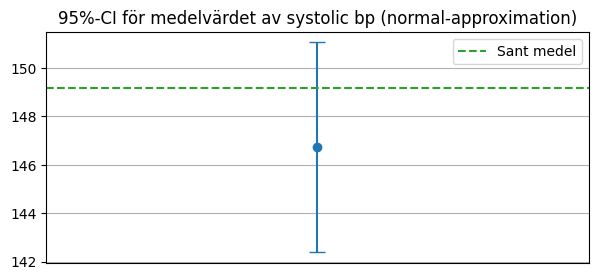

In [13]:
lo, hi, mean_x, s, n = analyzer.ci_mean_normal(sample)

fig, ax = plt.subplots(figsize=(7, 3))
ax.errorbar([0], [mean_x], yerr=[[mean_x - lo], [hi - mean_x]], fmt="o", capsize=6)
ax.axhline(true_mean, color="tab:green", linestyle="--", label="Sant medel")
ax.set_xticks([])
ax.grid(True, axis="y")
ax.legend()
ax.set_title("95%-CI för medelvärdet av systolic bp (normal-approximation)")

print(f"Normalaprroximation-CI: {lo:.1f} - {hi:.1f}")
print(f"Stickprovsmedel: {mean_x:.1f}     Sant medel: {true_mean:.1f}")

In [14]:
cov_normal = analyzer.covers_true_mean(
    systolic_bp, true_mean, method="normal")
cov_boot = analyzer.covers_true_mean(
    systolic_bp, true_mean, method="bootstrap")

cov_normal, cov_boot

(0.965, 0.93)

### Jämförelse av bootstrap och normalapproximation
Beräknade 95% konfidensintervall för medelvärdet med både bootstrap och normalapproximation.
Båda metoderna gav nästan identiska intervall:

**Bootstrap-CI: 142.4 - 151.0**

**Normalapproximation-CI: 142.8-151.1**

Även simuleringen av 200 upprepningar för att se hur ofta intervallen täcker det sanna medelvärdet visade liknande, normalapproximation: **~97%** samt bootstrap: **93%**.

### Hypotesprövning

In [15]:
results = bootstrap_bp_difference_by_smoking(df, n_boot=10_000)

print(f"Observerad skillnad (rökare - icke-rökare): {results['obs_diff']:.2f}")
print(f"Bootstrap p-värde: {results['p_value']:.3f}")

ci_low, ci_high = results["ci"]
print(f"95% CI: {ci_low:.1f} – {ci_high:.1f}")

Observerad skillnad (rökare - icke-rökare): 0.47
Bootstrap p-värde: 0.323
95% CI: -1.6 – 2.5


### Resultat
Jag använde mig av bootstrap metoden (10 000 stickprov) för att testa hypotesen att rökare har ett högre medel-blodtryck än icke rökare.

Den observerade skillnaden i medelvärde var ungefär **0.47** (rökare - icke-rökare). Envägs bootstrap-p-värdet blev ungefär **0.32**, vilket är så pass högt att hypotesen inte får stöd. 

Det 95-procentiga konfidensintervallet (**-1.6 till 2.5**) inkluderar dessutom noll.

### Slutsats
Det finns inget statistiskt stöd för att rökare har ett högre medel-blodtryck än icke rökare.

